In [1]:
import numpy as np
import dxchange
import xraylib as xlib
import xraylib_np as xlib_np
import xraydb as xdb
from scipy.ndimage import rotate as sp_rotate
from tqdm import tqdm
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 'truetype'
fontProperties = {'family': 'serif', 'serif': ['Helvetica'], 'weight': 'normal', 'size': 12}
plt.rc('font', **fontProperties)
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Define experimental coefficients

In [2]:
##Define the rotating angles of the sample
theta_st = 0
theta_end = 180
n_theta = 12
theta_ls = - np.linspace(theta_st, theta_end, n_theta)

## Define sample size in number of pixles on one side, assuing a N x N-pixel sample
sample_size = 20 

## Define sample size in cm on one side
sample_size_l = 0.01 

## Define probe posision, the position is defined to pass through the center of the voxel
prob_pos_ls = np.array([x for x in np.arange(sample_size)]) + 0.5
print(prob_pos_ls)

print((sample_size_l / sample_size)*1000)

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5]
0.5


## Define the elements in the sample

In [3]:
element_ls = np.array(["C", "O", "Si", "Ca", "Fe"])  
an_lib = {"C": 6, "O": 8, "Si": 14, "Ca": 20, "Fe": 26}

an_ls = np.array(list(an_lib.values()))
probe_energy = np.array([20.0])

## genrate the library of the total attenuation cross section for the involved elements at 20 keV
cs_probe_ls = xlib_np.CS_Total(an_ls, probe_energy).flatten()
cs_probe_lib = dict(zip(element_ls, cs_probe_ls))

aw_ls = xlib_np.AtomicWeight(an_ls)
aw_lib = dict(zip(element_ls, aw_ls)) 

In [4]:
# xraylib uses keV
fl_lines = np.array([xlib.KA2_LINE, xlib.KA1_LINE, xlib.KB1_LINE, xlib.LB1_LINE, xlib.LA2_LINE, xlib.LA1_LINE])

# xraydb uses eV
fl_lines_xdb = np.array(['Ka2', 'Ka1', 'Kb1', 'Lb1', 'La2', 'La1'])

det_energy_u = 20.0 ##keV
n_det_energy_bins = 2000
det_energy_list = np.linspace(det_energy_u / n_det_energy_bins, det_energy_u, 2000)
det_energy_list_full = np.linspace(- det_energy_u + det_energy_u / n_det_energy_bins, det_energy_u, n_det_energy_bins*2)
# print(det_energy_list)

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx, a.flat[idx]

# def MakeFLlinesDictionary(element_name, fl_lines_xdb, fl_lines, probe_energy):
FL_all_elements_dic = {"element_Line": [], "fl_energy": np.array([]), "detected_fl_unit_concentration": np.array([])}
for element_name in element_ls:
    print(element_name)
    fl_cs_ls = xlib_np.CS_FluorLine_Kissel_Cascade(np.array([an_lib[element_name]]), fl_lines, probe_energy)
#     print(fl_cs_ls)
    i = 0 
    for name, line in xdb.xray_lines(element_name).items():
        if name in set(fl_lines_xdb):
            element_Line = [element_name, name]
            FL_all_elements_dic["element_Line"].append(element_Line)
            FL_all_elements_dic["fl_energy"] = np.append(FL_all_elements_dic["fl_energy"], line[0]/1000)
            FL_all_elements_dic["detected_fl_unit_concentration"] = np.append(FL_all_elements_dic["detected_fl_unit_concentration"], fl_cs_ls[0,i][0])
            i+=1
    print(FL_all_elements_dic["element_Line"])
    print(len(FL_all_elements_dic["element_Line"]))
    print(FL_all_elements_dic["fl_energy"])
    print(FL_all_elements_dic["detected_fl_unit_concentration"])

C
[['C', 'Ka2'], ['C', 'Ka1']]
2
[0.277 0.277]
[9.43998503e-06 1.88251357e-05]
O
[['C', 'Ka2'], ['C', 'Ka1'], ['O', 'Ka2'], ['O', 'Ka1']]
4
[0.277  0.277  0.5249 0.5249]
[9.43998503e-06 1.88251357e-05 7.70355291e-04 1.53395894e-03]
Si
[['C', 'Ka2'], ['C', 'Ka1'], ['O', 'Ka2'], ['O', 'Ka1'], ['Si', 'Ka2'], ['Si', 'Ka1'], ['Si', 'Kb1']]
7
[0.277  0.277  0.5249 0.5249 1.7392 1.7398 1.837 ]
[9.43998503e-06 1.88251357e-05 7.70355291e-04 1.53395894e-03
 6.21552020e-02 1.23493777e-01 3.43441072e-03]
Ca
[['C', 'Ka2'], ['C', 'Ka1'], ['O', 'Ka2'], ['O', 'Ka1'], ['Si', 'Ka2'], ['Si', 'Ka1'], ['Si', 'Kb1'], ['Ca', 'Ka2'], ['Ca', 'Ka1'], ['Ca', 'Kb1']]
10
[0.277  0.277  0.5249 0.5249 1.7392 1.7398 1.837  3.6888 3.6923 4.0131]
[9.43998503e-06 1.88251357e-05 7.70355291e-04 1.53395894e-03
 6.21552020e-02 1.23493777e-01 3.43441072e-03 5.73454059e-01
 1.13349646e+00 1.42993637e-01]
Fe
[['C', 'Ka2'], ['C', 'Ka1'], ['O', 'Ka2'], ['O', 'Ka1'], ['Si', 'Ka2'], ['Si', 'Ka1'], ['Si', 'Kb1'], ['Ca', 'Ka2'], ['C

In [6]:
print(FL_all_elements_dic['detected_fl_unit_concentration'])

fl_cs_ls = xlib_np.CS_FluorLine_Kissel_Cascade(np.array([an_lib["C"]]), fl_lines, probe_energy)
print(fl_cs_ls)

print(fl_lines_xdb.shape[0])

[9.43998503e-06 1.88251357e-05 7.70355291e-04 1.53395894e-03
 6.21552020e-02 1.23493777e-01 3.43441072e-03 5.73454059e-01
 1.13349646e+00 1.42993637e-01 2.36742459e+00 4.63625614e+00
 6.24131266e-01 3.63050120e-02 1.10154924e-02 9.81422671e-02]
[[[9.43998503e-06]
  [1.88251357e-05]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]]
6


## Define the function that calculates the attenuation

In [7]:
def attenuation(src_path, theta_ls, sample_size, sample_size_l, element_ls):
    """
    Calculate the attenuation ratio of the incident beam before the beam travels to a certain voxel
    Assuming that the x-ray probe goes along the direction of axis=1 of the sample array
    
    Parameters
    ----------
    theta_ls: ndarray
        The angles that the sample rotates from the initial angle in the experiment
    
    sample_size: int scalar
        sample size in number of pixles on one side, assuing a N x N-pixel sample
    
    sample_size_l: scalar
        sample size in mm
    
    element_ls: ndarray
        elements in the sample
        
    Returns: ndarray
    -------
        dimension of the returned array is n_theta x sample_size x sample_size

    """
    att_acc_map = np.zeros((len(theta_ls), sample_size, sample_size))
    for i, theta in enumerate(theta_ls):
        for j, element in enumerate(element_ls):
            concentration_map_fname = os.path.join(src_path, element + '_map.tiff')
            concentration_map = dxchange.reader.read_tiff(concentration_map_fname)
            concentration_map_rot = sp_rotate(concentration_map, theta, reshape=False, order=1)
            lac_single = concentration_map_rot * cs_probe_lib[element]
            lac_acc = np.cumsum(lac_single, axis=1)  
            lac_acc = np.insert(lac_acc, 0, np.zeros(sample_size), axis=1)
            lac_acc = np.delete(lac_acc, sample_size, axis=1)
            att_acc = lac_acc * (sample_size_l / sample_size)
            att_acc_map[i,:,:] += att_acc
    return np.exp(-att_acc_map)

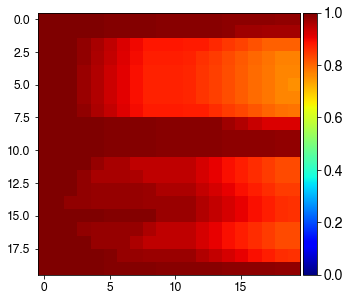

In [8]:
src_path = './data/sample1'
Att_probe = attenuation(src_path ,theta_ls, sample_size, sample_size_l, element_ls)

fig1 = plt.figure(figsize=(5,5))
gs1 = gridspec.GridSpec(nrows=1, ncols=1, width_ratios=[1])
fig1_ax1 = fig1.add_subplot(gs1[0,0])

pos = fig1_ax1.imshow(Att_probe[0,:,:], cmap='jet', vmin=0, vmax=1.0, origin='upper')
divider = make_axes_locatable(fig1_ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
# ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig1.colorbar(pos, cax=cax)
cbar.ax.tick_params(labelsize=14) 
# cbar.ax.set_title('intensity', size='14')

## Define the positions of detectorlets in terms of indices
### Defaul XRF detector parameters
1. The position of the XRF detector: 1.6 cm from the edge of the sample
2. The size of the XRF detector is 2.4 mm
3. The number of detectorlets is 5
4. The number of energy channels is 2000, from 0 - 20 keV

In [9]:
## Calculate the size of the voxel (unit in mm) using the length of the sample edge divided by the number of the pixels 
voxel_size = sample_size_l / sample_size
print(voxel_size)

## distance of the XRF detector from the sample edge
det_from_sample = 1.6

## diameter of the XRF detector
det_size_l = 0.24
det_size = np.ceil(det_size_l/voxel_size)

## number of the detectorlets
n_det = 5

## x index of the location of the XRF detector
det_axis_0_pixel = sample_size + np.ceil(det_from_sample/voxel_size) + 0.5
det_axis_0_pixel_ls = np.full(n_det, det_axis_0_pixel)

## y index of the location of the XRF detector
det_axis_1_pixel_ls = np.linspace(np.ceil(sample_size/2) - det_size, 
                                  np.ceil(sample_size/2) + det_size, n_det) + 0.5

## biding x-index and y-index array into [(x1,y1), (x2,y2), ..., (x_Ndet, y_Ndet)]
det_pos_ls = np.array(list(zip(det_axis_0_pixel_ls, det_axis_1_pixel_ls)))

print(det_axis_0_pixel_ls)
print(det_axis_1_pixel_ls)
print(det_pos_ls)
print(det_pos_ls[0])

0.0005
[3220.5 3220.5 3220.5 3220.5 3220.5]
[-469.5 -229.5   10.5  250.5  490.5]
[[3220.5 -469.5]
 [3220.5 -229.5]
 [3220.5   10.5]
 [3220.5  250.5]
 [3220.5  490.5]]
[3220.5 -469.5]


### Calculate the XRF signal for each beamlet at each signal

1. Calcualte FL_map, the emitted FL signal at each voxel given the intensity enters each voxel are all 1.
    - [x] For each element, look up the emitting energy of K$_\alpha$, K$_\beta$, L$_\alpha$ and L$_\beta$ lines at 20 eV probe beam. Combine 4 lines for each element, construct FL_map_unit, the emitting FL with units of dimension (n_element, 2000)
    - [x] For each angle, combine the map of elemental concentration with (FL_map_unit) to get FL_map
    - [x] The dimension of FL_map is (n_theta, sample_size * sample_size, 2000)


2. Calcualte the attenuation due to self absorption 
    - [x] First we need P, the intersecting length map for each beam path from the FL-emitting voxel to the detectorlet
    - [x] The dimension of P is (n_det, sample_size * sample_size, intersecting length) 

            
3. Then we calculate SA, the attenuation of each energy due to self-absorption(SA) from the FL-emitting voxel to the edge to the sample
    - [x] For each sample angle, summing over (map elemental concentration)$\odot$(map of intersecting length) and do an average over n_det detectorlets
    - [x] The dimension of SA is (n_theta, sample_size, sample_size, 2000)
    

4. Combine incident beam probe attenuation, FL_map and the self absorption to get the XRF signal for each beamlet at each signal
    - [ ] The expected size of data array is 2000 (the # of the energy channels) per beamlet per angle
    - [ ] The expected size of the total data array is (N_theta, sample_size, 2000)

### 1-1 Calculate FL_map_unit

In [10]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx, a.flat[idx]

## Returns fl cross section at each energy in det_energy_list per unit concentration of the element
def MakeFLlinesDictionary(element_name, fl_lines_xdb, fl_lines, probe_energy):
# for element_name in element_ls:
    FL_dic = {"element_Line": [], "fl_energy": np.array([]), "detected_fl_unit_concentration": np.array([])}
    fl_cs_ls = xlib_np.CS_FluorLine_Kissel_Cascade(np.array([an_lib[element_name]]), fl_lines, probe_energy)
    i = 0 
    for name, line in xdb.xray_lines(element_name).items():
        if name in set(fl_lines_xdb):
            element_Line = [element_name, name]
            FL_dic["element_Line"].append(element_Line)
            FL_dic["fl_energy"] = np.append(FL_dic["fl_energy"], line[0]/1000)
            FL_dic["detected_fl_unit_concentration"] = np.append(FL_dic["detected_fl_unit_concentration"], fl_cs_ls[0,i][0]* voxel_size)
            i+=1    
    return FL_dic

def Broadening_line(fl_unit, det_energy_list_full, sigma):
    fl_unit_f = np.fft.fft(fl_unit)
    b = (1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(det_energy_list_full**2)/(2*sigma**2))
    bf = np.fft.fft(b)
    broadening_signal = np.fft.ifftshift(np.fft.ifft(fl_unit_f*bf))
    
    return np.real(broadening_signal)

In [11]:
print(MakeFLlinesDictionary("C", fl_lines_xdb, fl_lines, probe_energy))
print(MakeFLlinesDictionary("C", fl_lines_xdb, fl_lines, probe_energy)["detected_fl_unit_concentration"])

{'element_Line': [['C', 'Ka2'], ['C', 'Ka1']], 'fl_energy': array([0.277, 0.277]), 'detected_fl_unit_concentration': array([4.71999252e-09, 9.41256786e-09])}
[4.71999252e-09 9.41256786e-09]


In [12]:
fl_lines_xdb = np.array(['Ka2', 'Ka1', 'Kb1', 'Lb1', 'La2', 'La1'])
fl_lines = np.array([xlib.KA2_LINE, xlib.KA1_LINE, xlib.KB1_LINE, xlib.LB1_LINE, xlib.LA2_LINE, xlib.LA1_LINE])

det_energy_u = 20.0E3
n_det_energy_bins = 2000
det_energy_list = np.linspace(det_energy_u / n_det_energy_bins, det_energy_u, n_det_energy_bins)
det_energy_list_full = np.linspace(- det_energy_u + det_energy_u / n_det_energy_bins, det_energy_u, n_det_energy_bins*2)
# print(det_energy_list)

sigma = 100 ## eV

## Calculate the FL signal emitted when shined by a incident beam with unit intensity
fl_map_tot = np.zeros((n_theta, sample_size * sample_size, len(FL_all_elements_dic["element_Line"])))
for i, theta in enumerate(theta_ls):
    kf = 0
    for j, element in enumerate(element_ls):
        concentration_map_fname = os.path.join(src_path, element + '_map.tiff')
        concentration_map = dxchange.reader.read_tiff(concentration_map_fname)
        concentration_map_rot = sp_rotate(concentration_map, theta, reshape=False, order=1)
        concentration_map_rot_flat = concentration_map_rot.flatten()
        
        ## FL signal emitted at unitary concentration of the current element over 2000 energy bins
        fl_unit = MakeFLlinesDictionary(element, fl_lines_xdb, fl_lines, probe_energy)["detected_fl_unit_concentration"]
        ki = kf
        kf = kf + len(fl_unit)
        ## FL signal of all lines from the current element from all voxels
        fl_map = np.array([fl_unit * concentration for concentration in concentration_map_rot_flat])
        ## construct the contribution from all elements
#         print(fl_map.shape)
        fl_map_tot[i,:,ki:kf] += fl_map
    
print(fl_map_tot[0,0,:])
print(fl_map_tot.shape)

[2.83199562e-09 5.64754094e-09 4.62213193e-07 9.20375402e-07
 3.10776014e-06 6.17468896e-06 1.71720538e-07 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
(12, 400, 16)


In [13]:
fl_lines_xdb = np.array(['Ka2', 'Ka1', 'Kb1', 'Lb1', 'La2', 'La1'])
fl_lines = np.array([xlib.KA2_LINE, xlib.KA1_LINE, xlib.KB1_LINE, xlib.LB1_LINE, xlib.LA2_LINE, xlib.LA1_LINE])

det_energy_u = 20.0E3
n_det_energy_bins = 2000
det_energy_list = np.linspace(det_energy_u / n_det_energy_bins, det_energy_u, n_det_energy_bins)
det_energy_list_full = np.linspace(- det_energy_u + det_energy_u / n_det_energy_bins, det_energy_u, n_det_energy_bins*2)
# print(det_energy_list)

offset = det_energy_u/2
sigma = 100 ## eV

def generate_fl_signal_from_each_voxel(src_path, sample_size, n_theta, theta_ls, element_ls, fl_lines_xdb, fl_lines, probe_energy, det_energy_u, n_det_energy_bins, det_energy_list, sigma):
    ## Calculate the FL signal emitted when shined by a incident beam with unit intensity
    fl_map_tot = np.zeros((n_theta, sample_size * sample_size, len(FL_all_elements_dic["element_Line"])))
    for i, theta in enumerate(theta_ls):
        kf = 0
        for j, element in enumerate(element_ls):
            concentration_map_fname = os.path.join(src_path, element + '_map.tiff')
            concentration_map = dxchange.reader.read_tiff(concentration_map_fname)
            concentration_map_rot = sp_rotate(concentration_map, theta, reshape=False, order=1)
            concentration_map_rot_flat = concentration_map_rot.flatten()
        
            ## FL signal emitted at unitary concentration of the current element over 2000 energy bins
            fl_unit = MakeFLlinesDictionary(element, fl_lines_xdb, fl_lines, probe_energy)["detected_fl_unit_concentration"]
            ki = kf
            kf = kf + len(fl_unit)
            
            ## delete the negative part of the energy array
            n_negative_energy = n_det_energy_bins
            negative_energy_index_ls = np.arange(n_negative_energy).tolist()
            fl_unit_b = np.delete(fl_unit_b, negative_energy_index_ls)
        
            ## FL signal over 2000 energy bins for each voxel
            fl_map = np.array([fl_unit_b * concentration for concentration in concentration_map_rot_flat])
            ## summing over the contribution from all elements
            fl_map_tot[i,:,:] += fl_map
    return  fl_map_tot

### 2-1: Define the function of line representing the beam path from the FL-emitting voxel to the detectorlets

In [14]:
## define a line passing through the FL emitting from the center of the source voxel (x1, y1) in the 2D sample 
## and the detectorlet (xd, yd)
def trace_beam_yint(x1, y1, xd, yd, sample_x_edge):
    m = (yd - y1)/(xd - x1)
    y_int = m * (sample_x_edge - x1) + y1
    return m, y_int

def trace_beam_xint(x1, y1, xd, yd, sample_y_edge):
    if yd == y1:
        m = 0
        x_int = np.array([])
    else:
        m = (yd - y1)/(xd - x1)
        x_int = (sample_y_edge - y1)/m + x1
    return m, x_int

### 2-2: Calculate P (the intersecting length map): 
1. for each detectorlect (total n_det)
2. for each voxel (total sample_size x sample_size)
3. we have a 2D map of intersecting length (total sample_size x sample_size)

#### The dimension of P:
(n_det, sample_size * sample_size, sample_size * sample_size)

#### P: environment of development

In [36]:
## define index position of center of the source voxel (x1, y1), note that it's shifted by 0.5 to represent the center
x1, y1 = np.indices((sample_size, sample_size))
x1, y1 = x1 + 0.5, y1 + 0.5
voxel_pos_ls = np.dstack((x1, y1))
print(voxel_pos_ls[0][0])

## define sample edges: 
## sample_x_edge is the edge that is closer to the XRF detector
## sample_y_edge has two components representing the left and the right edge
sample_x_edge = sample_size
sample_y_edge = np.array([0, sample_size])


## make voxel_pos_ls 1D array for looping: voxel_pos_ls_flat
voxel_pos_ls_flat =  np.reshape(voxel_pos_ls, (1, voxel_pos_ls.shape[0]*voxel_pos_ls.shape[0], 2))[0]

P = np.zeros((n_det, sample_size * sample_size, sample_size, sample_size))
# i = 0
for det_pos in det_pos_ls:
#     i+=1
#     j = 0
    for v in voxel_pos_ls_flat:
        j+=1
#         print("i, j = %d, %d" %(i, j))
        # find x-value when the beam passes through sample_y_edges(left & right), the one with larger x is the intersection with lower edge
        if v[1] == det_pos[1]:
            xint = sample_size
        else:
            xint = np.max(trace_beam_xint(v[0], v[1], det_pos[0], det_pos[1], sample_y_edge)[1])
        xint_sample = np.clip(xint, 0, sample_size)
        
        # find y-value when the beam passes through sample_x_edge(bottom)
        m = trace_beam_yint(v[0], v[1], det_pos[0], det_pos[1], sample_x_edge)[0]
        yint = trace_beam_yint(v[0], v[1], det_pos[0], det_pos[1], sample_x_edge)[1]
        yint_sample = np.clip(yint, 0, sample_size)
        
        
#         print('\n')
#         print('int. wi sample (x,y): (%.2f, %.2f)' %(xint_sample, yint_sample))
#         print('\n')
    
       
               
        # when the beam enters a voxel, it either intersects the x boundary or y boundary of the voxel
        # find the x,y-value of the boundary except the ones on the sample edge
        if np.floor(xint_sample) != np.floor(v[0]):
            x_edge_ls = np.linspace(np.ceil(xint_sample)-1, np.ceil(v[0]), int(np.abs(np.ceil(xint_sample) - np.ceil(v[0]))))
        else: 
            x_edge_ls = np.array([])
            
        
        if np.floor(yint_sample) != np.floor(v[1]):            
            if m < 0:
                y_edge_ls = np.linspace(np.floor(yint_sample)+1, np.floor(v[1]), int(np.abs(np.floor(yint_sample)+1 - np.floor(v[1]))) + 1)            
           
            if m > 0:
                y_edge_ls = np.linspace(np.ceil(yint_sample)-1, np.ceil(v[1]), int(np.abs(np.ceil(yint_sample) - np.ceil(v[1]))))
        else:
            y_edge_ls = np.array([])
        
#         print(x_edge_ls)
#         print(m)
#         print(y_edge_ls)
#         print('\n')
        
        # find all intersections (except the initial intersection): 
        # 1. find y-value of intersection given x_edge_ls
        # 2. find x-value of intersection given y_edge_ls
        y_int_x_edge_ls = trace_beam_yint(v[0], v[1], det_pos[0], det_pos[1], x_edge_ls)[1] #solve y intersections given x edge
        x_int_y_edge_ls = trace_beam_xint(v[0], v[1], det_pos[0], det_pos[1], y_edge_ls)[1] #solve x intersections given y edge
#         print('%.1f, %.1f, %.1f, %.1f'%(v[0], v[1], det_pos[0], det_pos[1]))
#         print('\n')
#         print('%.1f, %.1f' %(yint_sample, v[1]))
#         print(y_edge_ls)
#         print(x_int_y_edge_ls)
#         print('\n')
#         print(x_edge_ls)
#         print(y_int_x_edge_ls)
#         print('\n')
        
        # compile the x,y coordinates of the intersection: (x,y) = (x_edge_ls, y_int_x_edge_ls) and (x_int_y_edge_ls,y_edge_ls)
        int_x_edge_ls = np.dstack((x_edge_ls,y_int_x_edge_ls))[0]
        int_y_edge_ls = np.dstack((x_int_y_edge_ls,y_edge_ls))[0]
#         print(int_y_edge_ls)
        
        
        # mix all intersections
        # put the initial intersection [xint_sample, yint_sample] back
        # sort them using the x coordinate
        int_ls = np.concatenate((int_x_edge_ls, int_y_edge_ls))
        int_ls = np.vstack((np.array([xint_sample, yint_sample]), int_ls))
        int_ls = int_ls[np.argsort(int_ls[:,0])]
#         print(int_ls)
        
        # calculate the intersecting length in the intersecting voxels
        int_length = np.sqrt(np.diff(int_ls[:,0])**2 + np.diff(int_ls[:,1])**2)  
        # just in case that we count some intersections twice, delete the duplicates
        idx_duplicate = np.array(np.where(int_length==0)).flatten()
        int_ls = np.delete(int_ls, idx_duplicate, 0)
        int_length = np.delete(int_length, idx_duplicate) 
        
        # determine the indices of the intersecting voxels according to the intersecting x,y-coordinates
        int_ls_shift = np.zeros((int_ls.shape))
        int_ls_shift[1:] = int_ls[:-1]
        int_idx = np.floor((int_ls_shift + int_ls_shift)/2)[1:]
        
#         print(int_ls)
#         print(int_ls_shift)
#         print(int_idx)
#         print(int_idx.shape)
#         print(int_length)
#         print(int_length.shape)
        
        int_idx = (int_idx[:,0].astype('int'), int_idx[:,1].astype('int'))
        
        ## construct the int_length_map, and scale the intersecting length based on the voxel size
        int_length_map = np.zeros((sample_size, sample_size))
#         int_length_map[int_idx] = int_length * voxel_size
        int_length_map[int_idx] = int_length
        
#         a = pd.DataFrame(np.round(int_length_map, 2))        
#         a.columns = ['']*a.shape[1]
#         print(a.to_string(index=False))      

[0.5 0.5]


#### P: final work

In [45]:
## define index position of center of the source voxel (x1, y1), note that it's shifted by 0.5 to represent the center
x1, y1 = np.indices((sample_size, sample_size))
x1, y1 = x1 + 0.5, y1 + 0.5
voxel_pos_ls = np.dstack((x1, y1))

## define sample edges: 
## sample_x_edge is the edge that is closer to the XRF detector
## sample_y_edge has two components representing the left and the right edge
sample_x_edge = sample_size
sample_y_edge = np.array([0, sample_size])


## make voxel_pos_ls 1D array for looping: voxel_pos_ls_flat
voxel_pos_ls_flat =  np.reshape(voxel_pos_ls, (1, voxel_pos_ls.shape[0]*voxel_pos_ls.shape[0], 2))[0]

P = np.zeros((n_det, sample_size * sample_size, sample_size * sample_size))
for i, det_pos in enumerate(det_pos_ls):
    for j, v in enumerate(voxel_pos_ls_flat):
        # find x-value when the beam passes through sample_y_edges(left & right), the one with larger x is the intersection with lower edge
        if v[1] == det_pos[1]:
            xint = sample_size
        else:
            xint = np.max(trace_beam_xint(v[0], v[1], det_pos[0], det_pos[1], sample_y_edge)[1])
        xint_sample = np.clip(xint, 0, sample_size)
        
        # find y-value when the beam passes through sample_x_edge(bottom)
        m = trace_beam_yint(v[0], v[1], det_pos[0], det_pos[1], sample_x_edge)[0]
        yint = trace_beam_yint(v[0], v[1], det_pos[0], det_pos[1], sample_x_edge)[1]
        yint_sample = np.clip(yint, 0, sample_size)
    
               
        # when the beam enters a voxel, it either intersects the x boundary or y boundary of the voxel
        # find the x,y-value of the boundary except the ones on the sample edge
        if np.floor(xint_sample) != np.floor(v[0]):
            x_edge_ls = np.linspace(np.ceil(xint_sample)-1, np.ceil(v[0]), int(np.abs(np.ceil(xint_sample) - np.ceil(v[0]))))
        else: 
            x_edge_ls = np.array([])
            
        
        if np.floor(yint_sample) != np.floor(v[1]):            
            if m < 0:
                y_edge_ls = np.linspace(np.floor(yint_sample)+1, np.floor(v[1]), int(np.abs(np.floor(yint_sample)+1 - np.floor(v[1]))) + 1)            
           
            if m > 0:
                y_edge_ls = np.linspace(np.ceil(yint_sample)-1, np.ceil(v[1]), int(np.abs(np.ceil(yint_sample) - np.ceil(v[1]))))
        else:
            y_edge_ls = np.array([])
        
        
        # find all intersections (except the initial intersection): 
        # 1. find y-value of intersection given x_edge_ls
        # 2. find x-value of intersection given y_edge_ls
        y_int_x_edge_ls = trace_beam_yint(v[0], v[1], det_pos[0], det_pos[1], x_edge_ls)[1] #solve y intersections given x edge
        x_int_y_edge_ls = trace_beam_xint(v[0], v[1], det_pos[0], det_pos[1], y_edge_ls)[1] #solve x intersections given y edge
        
        # compile the x,y coordinates of the intersection: (x,y) = (x_edge_ls, y_int_x_edge_ls) and (x_int_y_edge_ls,y_edge_ls)
        int_x_edge_ls = np.dstack((x_edge_ls,y_int_x_edge_ls))[0]
        int_y_edge_ls = np.dstack((x_int_y_edge_ls,y_edge_ls))[0]

        # sort them using the x coordinate
        int_ls = np.concatenate((int_x_edge_ls, int_y_edge_ls))
        int_ls = np.vstack((np.array([xint_sample, yint_sample]), int_ls))
        int_ls = int_ls[np.argsort(int_ls[:,0])]
        
        # calculate the intersecting length in the intersecting voxels
        int_length = np.sqrt(np.diff(int_ls[:,0])**2 + np.diff(int_ls[:,1])**2) 
        # just in case that we count some intersections twice, delete the duplicates
        idx_duplicate = np.array(np.where(int_length==0)).flatten()
        int_ls = np.delete(int_ls, idx_duplicate, 0)
        int_length = np.delete(int_length, idx_duplicate) 
        
        # determine the indices of the intersecting voxels according to the intersecting x,y-coordinates
        int_ls_shift = np.zeros((int_ls.shape))
        int_ls_shift[1:] = int_ls[:-1]
        int_idx = np.floor((int_ls_shift + int_ls_shift)/2)[1:]        
        int_idx = (int_idx[:,0].astype('int'), int_idx[:,1].astype('int'))
        
        # construct the int_length_map, and scale the intersecting length based on the voxel size
        int_length_map = np.zeros((sample_size, sample_size))
#         int_length_map[int_idx] = int_length * voxel_size
        int_length_map[int_idx] = int_length  
         
        # determine the index of the current FL-emitting voxel, and fill P
#         x_idx_FL_vox = j // 20
#         y_idx_FL_vox = j % 20
#         print(int_length_map.shape)
#         print(P[i, j, :, :].shape)
        P[i, j, :] = int_length_map.flatten()

        a = pd.DataFrame(np.round(int_length_map, 2))        
        a.columns = ['']*a.shape[1]
        print(a.to_string(index=False))      
print(P.shape)
print("voxel_size = %f cm" %voxel_size)

                                                                                                    
 0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.94  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

KeyboardInterrupt: 

#### Generate P using a function

In [15]:
def intersecting_length_fl_detectorlet(n_det, sample_size):

    ## define index position of center of the source voxel (x1, y1), note that it's shifted by 0.5 to represent the center
    x1, y1 = np.indices((sample_size, sample_size))
    x1, y1 = x1 + 0.5, y1 + 0.5
    voxel_pos_ls = np.dstack((x1, y1))

    ## define sample edges: 
    ## sample_x_edge is the edge that is closer to the XRF detector
    ## sample_y_edge has two components representing the left and the right edge
    sample_x_edge = sample_size
    sample_y_edge = np.array([0, sample_size])


    ## make voxel_pos_ls 1D array for looping: voxel_pos_ls_flat
    voxel_pos_ls_flat =  np.reshape(voxel_pos_ls, (1, voxel_pos_ls.shape[0]*voxel_pos_ls.shape[0], 2))[0]

    P = np.zeros((n_det, sample_size * sample_size, sample_size * sample_size))
    for i, det_pos in enumerate(det_pos_ls):
        for j, v in enumerate(voxel_pos_ls_flat):
            # find x-value when the beam enters the sample WITHOUT intersecting the sample_y_edges(left & right), namely the beam is parallel with the y edge of the sample. 
            # find x-value when the beam passes through sample_y_edges(left & right), the one with larger x is the intersection with lower edge
            if v[1] == det_pos[1]:
                xint = sample_size
            else:
                xint = np.max(trace_beam_xint(v[0], v[1], det_pos[0], det_pos[1], sample_y_edge)[1])
            xint_sample = np.clip(xint, 0, sample_size)
        
            # find y-value when the beam passes through sample_x_edge(bottom)
            m = trace_beam_yint(v[0], v[1], det_pos[0], det_pos[1], sample_x_edge)[0]
            yint = trace_beam_yint(v[0], v[1], det_pos[0], det_pos[1], sample_x_edge)[1]
            yint_sample = np.clip(yint, 0, sample_size)
    
               
            # when the beam enters a voxel, it either intersects the x boundary or y boundary of the voxel
            # find the x,y-value of the boundary except the ones on the sample edge
            if np.floor(xint_sample) != np.floor(v[0]):
                x_edge_ls = np.linspace(np.ceil(xint_sample)-1, np.ceil(v[0]), int(np.abs(np.ceil(xint_sample) - np.ceil(v[0]))))
            else: 
                x_edge_ls = np.array([])
            
        
            if np.floor(yint_sample) != np.floor(v[1]):            
                if m < 0:
                    y_edge_ls = np.linspace(np.floor(yint_sample)+1, np.floor(v[1]), int(np.abs(np.floor(yint_sample)+1 - np.floor(v[1]))) + 1)            
           
                if m > 0:
                    y_edge_ls = np.linspace(np.ceil(yint_sample)-1, np.ceil(v[1]), int(np.abs(np.ceil(yint_sample) - np.ceil(v[1]))))
            else:
                y_edge_ls = np.array([])
        
        
            # find all intersections (except the initial intersection): 
            # 1. find y-value of intersection given x_edge_ls
            # 2. find x-value of intersection given y_edge_ls
            y_int_x_edge_ls = trace_beam_yint(v[0], v[1], det_pos[0], det_pos[1], x_edge_ls)[1] #solve y intersections given x edge
            x_int_y_edge_ls = trace_beam_xint(v[0], v[1], det_pos[0], det_pos[1], y_edge_ls)[1] #solve x intersections given y edge
        
            # compile the x,y coordinates of the intersection: (x,y) = (x_edge_ls, y_int_x_edge_ls) and (x_int_y_edge_ls,y_edge_ls)
            int_x_edge_ls = np.dstack((x_edge_ls,y_int_x_edge_ls))[0]
            int_y_edge_ls = np.dstack((x_int_y_edge_ls,y_edge_ls))[0]

            # sort them using the x coordinate
            int_ls = np.concatenate((int_x_edge_ls, int_y_edge_ls))
            int_ls = np.vstack((np.array([xint_sample, yint_sample]), int_ls))
            int_ls = int_ls[np.argsort(int_ls[:,0])]
        
            # calculate the intersecting length in the intersecting voxels
            int_length = np.sqrt(np.diff(int_ls[:,0])**2 + np.diff(int_ls[:,1])**2) 
            # just in case that we count some intersections twice, delete the duplicates
            idx_duplicate = np.array(np.where(int_length==0)).flatten()
            int_ls = np.delete(int_ls, idx_duplicate, 0)
            int_length = np.delete(int_length, idx_duplicate) 
        
            # determine the indices of the intersecting voxels according to the intersecting x,y-coordinates
            int_ls_shift = np.zeros((int_ls.shape))
            int_ls_shift[1:] = int_ls[:-1]
            int_idx = np.floor((int_ls_shift + int_ls_shift)/2)[1:]        
            int_idx = (int_idx[:,0].astype('int'), int_idx[:,1].astype('int'))
        
            # construct the int_length_map, and scale the intersecting length based on the voxel size
            int_length_map = np.zeros((sample_size, sample_size))
            int_length_map[int_idx] = int_length * voxel_size  
         
            P[i, j, :] = int_length_map.flatten()
    return P

### 3-1: Calculate SA (the map of attenuation ratio due to self-absorption of the FL signal):
1. for each sample angle (n_theta)
2. for each FL emitting voxel (sample_size x sample_size),
3. we have an attenuation ratio when the photon for each energy reaches the edge of the sample(due to self absorption)

#### The dimension of SA:
(n_theta, sample_size * sample_size, n_energy_bins)

In [20]:
det_energy_u = 20.0 # keV
n_det_energy_bins = 2000
det_energy_list = np.linspace(det_energy_u / n_det_energy_bins, det_energy_u, 2000)

## genrate the library of the total attenuation cross section for the involved elements from 0-20keV
att_cs_ls = xlib_np.CS_Total(an_ls, FL_all_elements_dic["fl_energy"])
att_cs_lib = dict(zip(element_ls, att_cs_ls))
print(att_cs_lib['O'][:])
print(att_cs_lib['C'].shape)

[ 6053.83236153  6053.83236153  1292.6214755   1292.6214755
  1028.99593778  1028.00645601   882.97770461   118.36875679
   118.03778857    92.24897178    22.88377186    22.74292605
    16.96113567 10291.80505265 10758.29123832 10758.29123832]
(16,)


In [22]:
P = intersecting_length_fl_detectorlet(n_det, sample_size)

SA = np.zeros((len(theta_ls), sample_size * sample_size, len(FL_all_elements_dic["element_Line"])))
for i, theta in enumerate(tqdm(theta_ls.tolist(), leave=False)):
    for j in np.arange(sample_size * sample_size):
#         print("i, j = %d, %d" %(i,j))       
        att_exponent_elemental_sum_temp = np.zeros((len(element_ls), n_det, len(FL_all_elements_dic["element_Line"])))
        for k, element in enumerate(element_ls):
            concentration_map_fname = os.path.join(src_path, element + '_map.tiff')
            concentration_map = dxchange.reader.read_tiff(concentration_map_fname)
            concentration_map_rot = sp_rotate(concentration_map, theta, reshape=False, order=1)
            ## flattened concentration_map after rotation (n_theta, sample_size * sample_size)
            concentration_map_rot_flat = concentration_map_rot.flatten()
            
            ## linear attenuation coefficient for each fl-line at each voxel: (sample_size * sample_size, len(FL_all_elements_dic["element_Line"]))
            lac = np.array([att_cs_lib[element] * concentration for concentration in concentration_map_rot_flat])
#             print(att_cs_lib[element][27])
#             print(concentration_map_rot_flat[42])
#             print(lac[42, 27])
            
            ## att_exponent = [(intersecting_length_path1 * lac), (intersecting_length_path2 * lac), ..., (intersecting_length_path5 * lac)]:
            ## att_exponent (for each fl-line, at each_voxel, for each beam path): (n_det, sample_size * sample_size, len(FL_all_elements_dic["element_Line"]))
            att_exponent = np.array([P[m,j,:][:,np.newaxis] * lac for m in range(n_det)])

            
            ## att_exponent summing over voxels (for each energy, for each beam path): (n_det, len(FL_all_elements_dic["element_Line"]))
            att_exponent_voxel_sum = np.sum(att_exponent, axis=1)

            ## filling att_exponent_voxel_sum to att_exponent_elemental_sum for each element: 
            att_exponent_elemental_sum_temp[k, :, :] = att_exponent_voxel_sum
#             print(att_exponent_elemental_sum_temp[1, 4, 27])
#             print("\n")
            
        ## summing over the attenation exponent contributed by each element
        att_exponent_elemental_sum =  np.sum(att_exponent_elemental_sum_temp, axis=0) 
        
        
        ## calculate the attenuation caused by all elements
        att = np.exp(- att_exponent_elemental_sum)
        ## calculate the attenuation averaged all paths
        att_path_ave = np.average(att, axis=0)
        SA[i,j,:] = att_path_ave
print(SA.shape)


100%|██████████| 12/12 [01:10<00:00,  6.57s/it]
                                               

(12, 400, 16)


In [29]:
def self_absorption_ratio(theta_ls, sample_size, n_det_energy_bins, src_path, element_ls, att_cs_lib, n_det):

    SA = np.zeros((len(theta_ls), sample_size * sample_size, len(FL_all_elements_dic["element_Line"])))
    for i, theta in enumerate(tqdm(theta_ls.tolist(), leave=False)):
        for j in np.arange(sample_size * sample_size):
        
            att_exponent_elemental_sum_temp = np.zeros((len(element_ls), n_det, len(FL_all_elements_dic["element_Line"])))
            for k, element in enumerate(element_ls):
                concentration_map_fname = os.path.join(src_path, element + '_map.tiff')
                concentration_map = dxchange.reader.read_tiff(concentration_map_fname)
                concentration_map_rot = sp_rotate(concentration_map, theta, reshape=False, order=1)
                ## flattened concentration_map after rotation (n_theta, sample_size * sample_size)
                concentration_map_rot_flat = concentration_map_rot.flatten()
            
                ## linear attenuation coefficient for each energy at each voxel: (sample_size * sample_size, n_eneygy_bins)
                lac = np.array([att_cs_lib[element] * concentration for concentration in concentration_map_rot_flat])
            
                ## att_exponent = [(intersecting_length_path1 * lac), (intersecting_length_path2 * lac), ..., (intersecting_length_path5 * lac)]:
                ## att_exponent (for each energy, at each_voxel, for each beam path): (n_det, sample_size * sample_size, n_eneygy_bins)
                att_exponent = np.array([P[m,j,:][:,np.newaxis] * lac for m in range(n_det)])
            
                ## att_exponent summing over voxels (for each energy, for each beam path): (n_det, n_eneygy_bins)
                att_exponent_voxel_sum = np.sum(att_exponent, axis=1)

                ## filling att_exponent_voxel_sum to att_exponent_elemental_sum for each element
                att_exponent_elemental_sum_temp[k, :, :] = att_exponent_voxel_sum
        
            ## summing over the attenation exponent contributed by each element: (n_det, n_eneygy_bins)
            att_exponent_elemental_sum =  np.sum(att_exponent_elemental_sum_temp, axis=0) 
        
        
            ## calculate the attenuation caused by all elements: (n_det, n_eneygy_bins)
            att = np.exp(- att_exponent_elemental_sum)
            ## calculate the attenuation averaged all paths: (n_eneygy_bins,)
            att_path_ave = np.average(att, axis=0)
            SA[i,j,:] = att_path_ave
    return SA

In [30]:
SA = self_absorption_ratio(theta_ls, sample_size, n_det_energy_bins, src_path, element_ls, att_cs_lib, n_det)

print(SA.shape)
SA_re = SA.reshape(12,20,20,16)


100%|██████████| 12/12 [01:05<00:00,  6.36s/it]
                                               

(12, 400, 16)


[7.27490028e-51 7.27490028e-51 5.49700696e-40 5.49700696e-40
 1.85607488e-07 1.88265095e-07 1.51328325e-06 6.62578941e-02
 6.66959403e-02 1.12534558e-01 3.51711145e-01 3.53195028e-01
 4.25331526e-01 2.43232795e-66 2.25690431e-69 2.25690431e-69]
[2.65558054e-48 2.65558054e-48 2.18252185e-38 2.18252185e-38
 2.09386926e-07 2.12198412e-07 1.49811784e-06 4.00178584e-02
 4.02965493e-02 7.07003031e-02 1.96427162e-01 1.97505952e-01
 2.54250432e-01 1.46095325e-62 2.72536409e-65 2.72536409e-65]
[-2.64830564e-48 -2.64830564e-48 -2.12755178e-38 -2.12755178e-38
 -2.37794371e-08 -2.39333172e-08  1.51654090e-08  2.62400356e-02
  2.63993910e-02  4.18342546e-02  1.55283983e-01  1.55689076e-01
  1.71081094e-01 -1.46071002e-62 -2.72513840e-65 -2.72513840e-65]


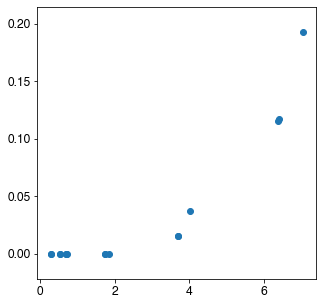

In [32]:
print(SA[0,10,])
print(SA[0,11,:])
print(SA[0,10,:]-SA[0,11,:])
plt.figure(figsize = (5,5))
plt.scatter(FL_all_elements_dic["fl_energy"] ,SA[0,4,:])

## 4. Let's make the cake with the prepared ingredient!

### 4-1: Combine probe attenuation and the self absorbtion to get XRF signal!

In [83]:
def repeat(arr, count):
    return np.stack([arr for _ in range(count)], axis=0)

In [33]:
src_path = './data/sample1'

## create the profile of the probe
# create 1-D profile along axis 0, and then make it 2-D by copying the 1-D profile array along axis 1
probe_intensity_1D = np.ones((sample_size, 1))
probe_intensity_2D = probe_intensity_1D * np.ones((sample_size, sample_size))
# flatten the array: (400,)
probe_intensity_2D_flat = probe_intensity_2D.flatten()
# print(probe_intensity_2D_flat.shape)

## create the array representing the ratio of remaining intensity after the attenuation along the incident direction of the probe
# flatten it: (n_theta, sample_size * sample_size)
att_flat = attenuation(src_path ,theta_ls, sample_size, sample_size_l, element_ls).reshape(n_theta, sample_size * sample_size)
# print(att_flat.shape)

## Calculate the remaining intensity of the probe at each voxel at each sample angle
att_probe_flat = probe_intensity_2D_flat * att_flat
# print(att_probe_flat.shape)
# flatten the calculated results and reshape it into a 2-D array with length=1 along axis 1
att_probe_flat2 = att_probe_flat.flatten()
att_probe_flat2 = np.array(att_probe_flat2[:,np.newaxis])
# print(att_probe_flat2.shape)

## Calculate the generated fluorescence signal based on the attenuated probe
# print(fl_map_tot.shape)
fl_map_tot_flat = fl_map_tot.reshape(n_theta*sample_size*sample_size, len(FL_all_elements_dic["element_Line"]))
# print(fl_map_tot_flat.shape)
fl_signal_flat = att_probe_flat2 * fl_map_tot_flat
print(fl_signal_flat.shape)

## flatten self-absroption matrix
# print(SA.shape)
SA_flat = SA.reshape(n_theta*sample_size*sample_size, len(FL_all_elements_dic["element_Line"]))
print(SA_flat.shape)

## Calculated the fluorescence signal collected by the detector after self-absorption
fl_signal_SA_flat = fl_signal_flat * SA_flat
print(fl_signal_SA_flat.shape)

fl_signal_SA = fl_signal_SA_flat.reshape(n_theta, sample_size, sample_size, len(FL_all_elements_dic["element_Line"]))
print(fl_signal_SA.shape)

fl_signal_SA_beamlet = np.sum(fl_signal_SA, axis=2)
print(fl_signal_SA_beamlet.shape)

np.save('./data/XRF_sample1.npy', fl_signal_SA_beamlet)

(4800, 16)
(4800, 16)
(4800, 16)
(12, 20, 20, 16)
(12, 20, 16)


In [34]:
def create_XRT_data(src_path, sample_size, sample_size_l, n_theta, theta_ls, element_ls, att_cs_lib, probe_intensity_1D):

    ## create the profile of the probe
    # create 1-D profile along axis 0, and then make it 2-D by copying the 1-D profile array along axis 1
    probe_intensity_2D = probe_intensity_1D * np.ones((sample_size, sample_size))
    # flatten the array: (400,)
    probe_intensity_2D_flat = probe_intensity_2D.flatten()
    # print(probe_intensity_2D_flat.shape)

    ## create the array representing the ratio of remaining intensity after the attenuation along the incident direction of the probe
    # flatten it: (n_theta, sample_size * sample_size)
    att_flat = attenuation(src_path ,theta_ls, sample_size, sample_size_l, element_ls).reshape(n_theta, sample_size * sample_size)
    # print(att_flat.shape)
    
    ## Calculate the remaining intensity of the probe at each voxel at each sample angle
    att_probe_flat = probe_intensity_2D_flat * att_flat
    
    att_probe = att_probe_flat.reshape(n_theta, sample_size, sample_size)
    # print(att_probe.shape)
    # print(att_probe)

    XRT = att_probe[:,:,-1]
    # print(XRT.shape)
    # print(XRT)
    np.save('./data/XRT_sample1.npy', XRT)
    return

In [36]:
def create_XRF_data(src_path, sample_size, sample_size_l, n_theta, theta_ls, element_ls, att_cs_lib, probe_intensity_1D, n_det_energy_bins, n_det):

    ## create the profile of the probe
    # create 1-D profile along axis 0, and then make it 2-D by copying the 1-D profile array along axis 1
    probe_intensity_2D = probe_intensity_1D * np.ones((sample_size, sample_size))
    # flatten the array: (400,)
    probe_intensity_2D_flat = probe_intensity_2D.flatten()
    # print(probe_intensity_2D_flat.shape)

    ## create the array representing the ratio of remaining intensity after the attenuation along the incident direction of the probe
    # flatten it: (n_theta, sample_size * sample_size)
    att_flat = attenuation(src_path ,theta_ls, sample_size, sample_size_l, element_ls).reshape(n_theta, sample_size * sample_size)
    # print(att_flat.shape)

    ## Calculate the remaining intensity of the probe at each voxel at each sample angle
    att_probe_flat = probe_intensity_2D_flat * att_flat
    # print(att_probe_flat.shape)
    # flatten the calculated results and reshape it into a 2-D array with length=1 along axis 1
    att_probe_flat2 = att_probe_flat.flatten()
    att_probe_flat2 = np.array(att_probe_flat2[:,np.newaxis])
    # print(att_probe_flat2.shape)

    ## Calculate the generated fluorescence signal based on the attenuated probe
    # print(fl_map_tot.shape)
    fl_map_tot_flat = fl_map_tot.reshape(n_theta*sample_size*sample_size, len(FL_all_elements_dic["element_Line"]))
    # print(fl_map_tot_flat.shape)
    fl_signal_flat = att_probe_flat2 * fl_map_tot_flat
    print(fl_signal_flat.shape)

    ## flatten self-absroption matrix
    # print(SA.shape)
    SA_flat = SA.reshape(n_theta*sample_size*sample_size, len(FL_all_elements_dic["element_Line"]))
    print(SA_flat.shape)

    ## Calculated the fluorescence signal collected by the detector after self-absorption
    fl_signal_SA_flat = fl_signal_flat * SA_flat
    print(fl_signal_SA_flat.shape)

    fl_signal_SA = fl_signal_SA_flat.reshape(n_theta, sample_size, sample_size, len(FL_all_elements_dic["element_Line"]))
    print(fl_signal_SA.shape)

    fl_signal_SA_beamlet = np.sum(fl_signal_SA, axis=2)
    print(fl_signal_SA_beamlet.shape)

    np.save('./data/XRF_sample1.npy', fl_signal_SA_beamlet)
    
    return

In [37]:
src_path = './data/sample1'
probe_intensity_1D = np.ones((sample_size, 1))
create_XRF_data(src_path, sample_size, sample_size_l, n_theta, theta_ls, element_ls, att_cs_lib, probe_intensity_1D, n_det_energy_bins, n_det)

create_XRT_data(src_path, sample_size, sample_size_l, n_theta, theta_ls, element_ls, att_cs_lib, probe_intensity_1D)

(4800, 16)
(4800, 16)
(4800, 16)
(12, 20, 20, 16)
(12, 20, 16)


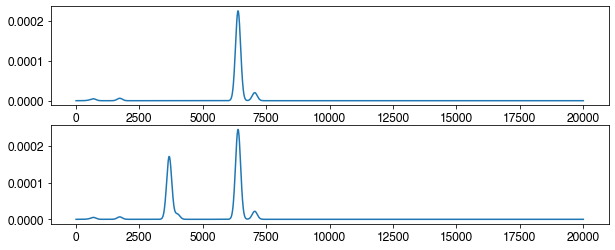

In [292]:
a = fl_signal_SA_beamlet.reshape(n_theta, sample_size, n_det_energy_bins)[0,0,:]
a1 = fl_signal_SA_beamlet.reshape(n_theta, sample_size, n_det_energy_bins)[1,10,:]
# print(np.nonzero(a-a1))

plt.figure(figsize=(10,4))
plt.subplot(211)
plt.plot(det_energy_list, a)
# plt.xlim(0,10000)
# plt.ylim(0,0.0005)

plt.subplot(212)
plt.plot(det_energy_list, a1)
# plt.xlim(0,10000)
# plt.ylim(0,0.00000005)

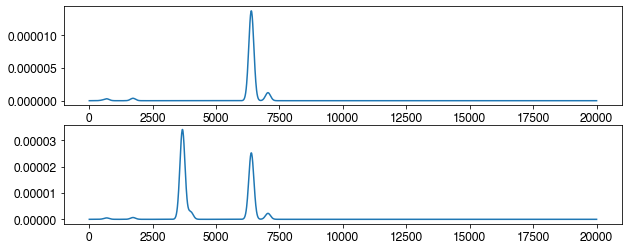

In [261]:
b = fl_signal_SA[0,0,:]
b1 = fl_signal_SA[0,34,:]
# print(np.nonzero(a-b))

plt.figure(figsize=(10,4))
plt.subplot(211)
plt.plot(det_energy_list, b)
# plt.xlim(0,10000)
# plt.ylim(0,0.0005)

plt.subplot(212)
plt.plot(det_energy_list, b1)
# plt.xlim(0,10000)
# plt.ylim(0,0.00000005)

In [255]:
idx_nonzero = np.nonzero(fl_signal_flat-fl_signal_SA_flat)
print(np.argwhere(fl_signal_flat-fl_signal_SA_flat == 0))
# SA_difference = fl_signal_flat[idx_nonzero] - fl_signal_SA_flat[idx_nonzero]
# print(np.max(SA_difference))

# plt.figure(figsize = (5,5))
# plt.scatter(idx_nonzero[0],idx_nonzero[1])

[[ 380    0]
 [ 380    1]
 [ 380    2]
 ...
 [4799 1997]
 [4799 1998]
 [4799 1999]]


In [137]:
a = np.array([[[1,1],[1,1]], [[3,4],[5,6]], [[6,7],[8,9]]])


print(a.shape)
print('\n')

b = np.sum(a, axis=1)
print(b)
print('\n')

c = np.sum(a, axis=0)
print(c)
print('\n')


(3, 2, 2)


[[ 2  2]
 [ 8 10]
 [14 16]]


[[10 12]
 [14 16]]




In [156]:
def repeat(arr, count):
    return np.stack([arr for _ in range(count)], axis=0)

# a = np.array([[1,1],[1,1]])
# aa = repeat(a,2)
# print(aa)

a1 = np.array([[1,2,3,4,5,6,7,8], [2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8], [2,3,4,5,6,7,8,9]])  ## lac
a2 = 2 * np.array([[1,2,3,4,5,6,7,8], [2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8], [2,3,4,5,6,7,8,9]])  ## lac
b = np.array([[1,1,1,1], [2,2,2,2], [3,3,3,3], [4,4,4,4], [5,5,5,5]])  ## intersecting length


c0 = b[0,:][:,np.newaxis]
c1 = b[1,:][:,np.newaxis]
c2 = b[2,:][:,np.newaxis]
c3 = b[3,:][:,np.newaxis]
c4 = b[4,:][:,np.newaxis]
 
# d1 = (c0 + c1 + c2 + c3 + c4) * a1 / 5
d0 = np.zeros((2, 5, 8))
d2 = np.array([b[i,:][:,np.newaxis] * a1 for i in range(5)])
d3 = np.array([b[i,:][:,np.newaxis] * a2 for i in range(5)])


d4 = np.sum(d2, axis=1) ## summing over voxels
d5 = np.sum(d3, axis=1) ## summing over voxels
d0[0,:,:] = d4
d0[1,:,:] = d5

d6 = np.sum(d0, axis=0) ## summing over elements

# print(d2)
# print('\n')
# print(d4)
# print('\n')
# print(d3)
# print('\n')
# print(d5)
print('\n')
print(d0)
print('\n')
print(d6)



[[[  6.  10.  14.  18.  22.  26.  30.  34.]
  [ 12.  20.  28.  36.  44.  52.  60.  68.]
  [ 18.  30.  42.  54.  66.  78.  90. 102.]
  [ 24.  40.  56.  72.  88. 104. 120. 136.]
  [ 30.  50.  70.  90. 110. 130. 150. 170.]]

 [[ 12.  20.  28.  36.  44.  52.  60.  68.]
  [ 24.  40.  56.  72.  88. 104. 120. 136.]
  [ 36.  60.  84. 108. 132. 156. 180. 204.]
  [ 48.  80. 112. 144. 176. 208. 240. 272.]
  [ 60. 100. 140. 180. 220. 260. 300. 340.]]]


[[ 18.  30.  42.  54.  66.  78.  90. 102.]
 [ 36.  60.  84. 108. 132. 156. 180. 204.]
 [ 54.  90. 126. 162. 198. 234. 270. 306.]
 [ 72. 120. 168. 216. 264. 312. 360. 408.]
 [ 90. 150. 210. 270. 330. 390. 450. 510.]]


In [228]:
a = np.array([[1,1,1],[2,2,2]])
b = np.array([2,3,4])

print(a)
print(b)
print(a*b)

[[1 1 1]
 [2 2 2]]
[2 3 4]
[[2 3 4]
 [4 6 8]]


In [23]:
a = np.array([1,2,2,1])
a = np.array(a[:, np.newaxis])
b = np.ones((4, 4))
print(a)
print(b)
print(a*b)

[[1]
 [2]
 [2]
 [1]]
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[[1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [1. 1. 1. 1.]]


In [270]:
def repeat(arr, count):
    return np.stack([arr for _ in range(count)], axis=0)

a = np.array([[[1,2,3],[2,3,4],[3,4,5],[4,5,6],[5,6,7],[6,7,8],[7,8,9],[9,9,9],[9,9,9]],
              [[2,3,4],[2,3,4],[2,3,4],[2,3,4],[2,3,4],[2,3,4],[2,3,4],[2,3,4],[2,3,4]],
              [[3,4,5],[3,4,5],[3,4,5],[3,4,5],[3,4,5],[3,4,5],[3,4,5],[3,4,5],[3,4,5]],
              [[4,5,6],[4,5,6],[4,5,6],[4,5,6],[4,5,6],[4,5,6],[4,5,6],[4,5,6],[4,5,6]]])
print(a.shape)
print(a)

b = np.sum(a, axis=1)
print(b.shape)
print(b)

# b = np.array([0.1,0.2,0.3,0.4])
# b = np.array(b[:, np.newaxis])
# print(b.shape)
# print(b)

# d = a[0]
# print(d)

(4, 9, 3)
[[[1 2 3]
  [2 3 4]
  [3 4 5]
  [4 5 6]
  [5 6 7]
  [6 7 8]
  [7 8 9]
  [9 9 9]
  [9 9 9]]

 [[2 3 4]
  [2 3 4]
  [2 3 4]
  [2 3 4]
  [2 3 4]
  [2 3 4]
  [2 3 4]
  [2 3 4]
  [2 3 4]]

 [[3 4 5]
  [3 4 5]
  [3 4 5]
  [3 4 5]
  [3 4 5]
  [3 4 5]
  [3 4 5]
  [3 4 5]
  [3 4 5]]

 [[4 5 6]
  [4 5 6]
  [4 5 6]
  [4 5 6]
  [4 5 6]
  [4 5 6]
  [4 5 6]
  [4 5 6]
  [4 5 6]]]
(4, 3)
[[46 53 60]
 [18 27 36]
 [27 36 45]
 [36 45 54]]
